In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time, VolumeGrouper
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate, calibrate_multiple, get_data
from datastore import Store

In [2]:
sym = 'NQ'
volume = 10000
start_date = '20190101'
end_date = '20191231'

In [3]:
#data = VolumeGrouper(get_data(sym, start_date, end_date), volume).df
data = get_data(sym, start_date, end_date)

In [4]:
def ema(data, fast, slow):
    data = data.copy()
    data['ema_slow'] = data.close.ewm(span=slow).mean()
    data['ema_fast'] = data.close.ewm(span=fast).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    return data['ema_diff']

In [5]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [6]:
def carver(data, periods):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    return np.sign(data['breakout'])

In [7]:
day = 1365
data['forecast'] = carver(data, int(day*90))

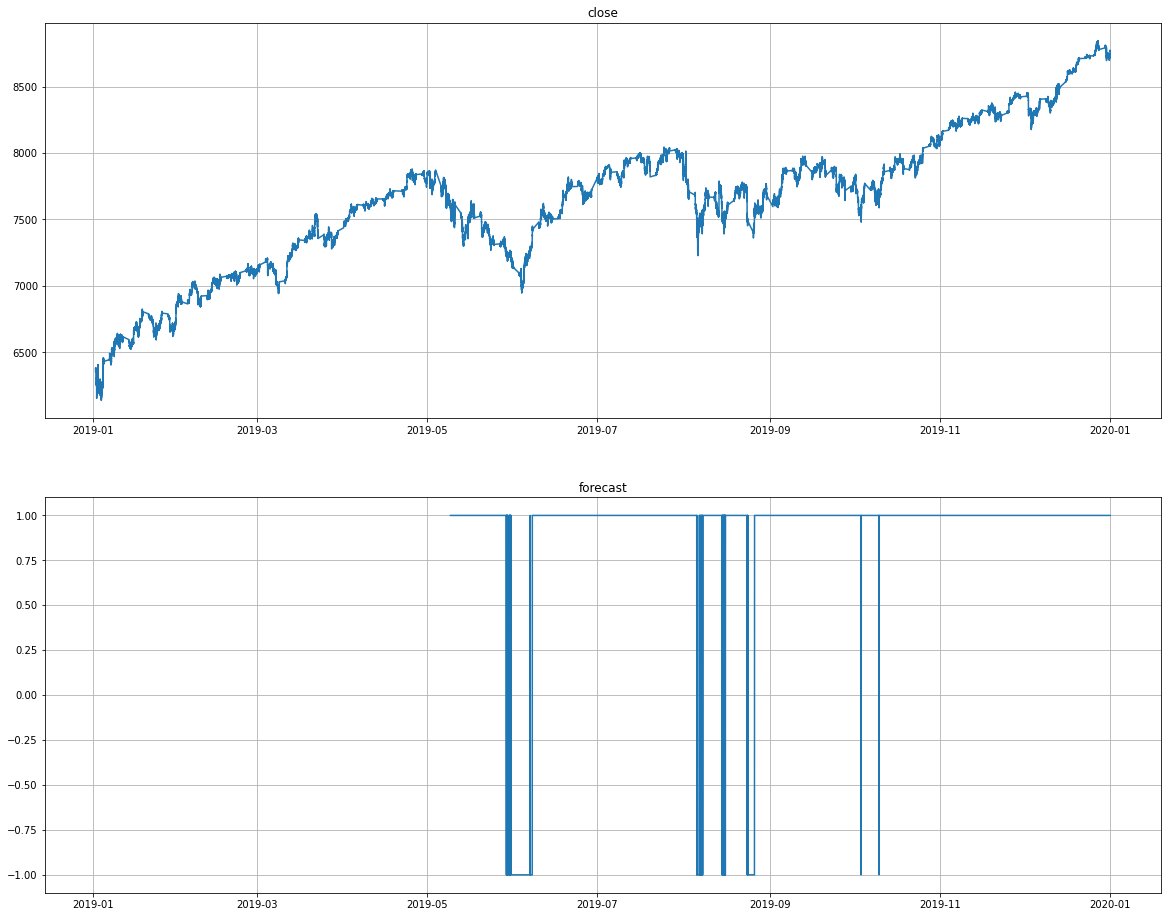

In [8]:
plot(data[['close', 'forecast']])

In [9]:
out = summary(data, slip=1.5, )
out.stats

,0
Annual return,-0.0958095
Cumulative returns,-0.0979752
Annual volatility,0.152972
Sharpe ratio,-0.581119
Calmar ratio,-0.435379
Stability,0.6732
Max drawdown,-0.22006
Omega ratio,0.878601
Sortino ratio,-0.69851
Skew,-1.81896


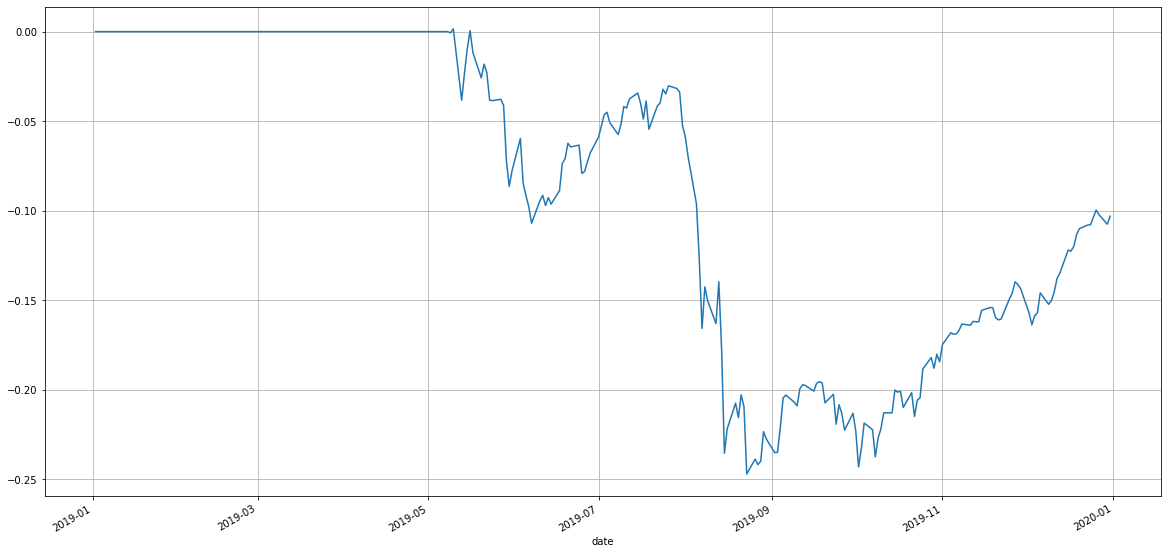

In [10]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [11]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

KeyError: 5

In [ ]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

In [ ]:
out.dfs[0].loc['20190719 2:40':'20190720'].head(30)

In [ ]:
out.positions[0].head(30)

In [ ]:
out.positions[0].sort_values('pnl')

In [ ]:
d = data.copy()
d['max'] = data.close.rolling(day*2).max()
d['min'] = data.close.rolling(day*2).min()
d['mid'] = d[['min', 'max']].mean(axis=1)
d['breakout'] = d['close'] - d['mid']
d['breakout_norm'] = d['breakout'] / (d['max'] - d['min'])
d['breakout_mean'] = d['breakout_norm'].ewm(span=day*2/3).mean()
d=d.loc['20190719':'20190720']
d[['max', 'min', 'mid', 'close',]].plot(figsize=(20,10), grid=True);

In [ ]:
data.loc['20190719 2:40':'20190720'].head(30)

In [ ]:
def test_carver(data, periods):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['span'] = (data['max'] - data['min'])
    data['breakout_norm'] = data['breakout'] / data['span']
    data[f'carver_{periods}'] = data['breakout_norm'].ewm(span=periods/3).mean()
    return data

In [ ]:
t=test_carver(data, day*2).loc['20190719 2:40':'20190720'].head(30)
t

In [ ]:
t[['breakout_norm','carver_2730']].loc['20190719 2:40':'20190720'].plot(figsize=(20,10), grid=True)